In [1]:
import deeptime
import matplotlib.pyplot as plt
import pyemma
import numpy as np
import mdshare
import mdtraj as mdt
import glob

In [2]:
%matplotlib inline

In [3]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

# Markov State Model Analysis

In this series of notebooks, we're going to noodle our way through the various stages of MSM creation and estimation, based on the PyEmma tutorials and the 2014 textbook "An Introduction to Markov State Models and Their Application to Long Timescale Molecular Simulation." We're  going to try to use the `deeptime` package and the `msmbuilder` package in place of the `PyEmma` one.

We begin with the first step (http://www.emma-project.org/latest/tutorials/notebooks/02-dimension-reduction-and-discretization.html), for which we will focus on the pentapeptide system.  This is clustering of the system into *microstates* using some preferred clustering algorithm. 

### From the PyEmma Tutorials

Before we start to load and discretize the pentapeptide data set, let us discuss what the difficulties with larger protein systems are. The goal of this notebook is to find a state space discretization for MSM estimation. This means that an algorithm such as $k$-means has to be able to find a meaningful state space partitioning. In general, this works better in lower dimensional spaces because Euclidean distances become less meaningful with increasing dimensionality [aggarwal-01]. The modeler should be aware that a discretization of hundreds of dimensions will be computationally expensive and most likely yield unsatisfactory results.

The first goal is thus to map the data to a reasonable number of dimensions, e.g., with a smart choice of features and/or by using TICA (or another dimensionality reduction procedure -- RAM). Large systems often require significant parts of the kinetic variance to be discarded in order to obtain a balance between capturing as much of the kinetic variance as possible and achieving a reasonable discretization.

Another point about discretization algorithms is that one should bear in mind the distribution of density. The $k$-means algorithm tends to conserve density, i.e., data sets that incorporate regions of extremely high density as well as poorly sampled regions might be problematic, especially in high dimensions. For those cases, a regular spatial clustering might be worth a try.

Now, we fetch the pentapeptide data set, load several different input features into memory and perform a VAMP estimation/scoring of each. Since we want to evaluate the VAMP score on a disjoint test set, we split the available files into a train and test set.

In [4]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

In [5]:
trajs = []
for f in files:
    traj = mdt.load(f,top=pdb)
    trajs.append(traj)

In [6]:
trajs

[<mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191affd6a50>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191aa340ad0>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191b09ef850>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191b0888610>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191aa7dbb10>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191b0a84610>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191b0a43650>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191b1058d10>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191b0a67d50>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitcells at 0x191b0947150>,
 <mdtraj.Trajectory with 5001 frames, 94 atoms, 5 residues, and unitce

To approximately follow the PyEmma tutorial, we will need to explicitly featurize each trajectory, in terms of all torsions (bb + sidechain), in terms of the distances between the alpha carbons, and in terms of the contacts between the heavy atoms.  That means we will have three different sets of data. We will also need to divide into train and test sets and associate one matrix with each set.

In [7]:
train_trajs = trajs[:-2]
test_trajs = trajs[-2]  # last trajectory is our test data set
assert set(train_trajs) & set(test_trajs) == set()  # ensure test and train sets do not overlap

In [8]:
X = np.random.rand(10,3)
Y = np.random.rand(10,5)
np.hstack([X,Y]).shape

(10, 8)

We use our in-house defined functions based on `mdtraj` to extract all torsions (bb+sidechain), the distances between alpha carbons, and the contacts between the heavy atoms.  These functions are `local_dihedral_featurizer`, `local_ca_distances_featurizer`, and `local_heavy_contacts_featurizer` (see the accompanying `localfeaturizers.py` file).

In [9]:
from localfeaturizers import local_dihedral_featurizer, local_ca_distances_featurizer, local_heavy_contacts_featurizer

In [10]:
dihslist_train = local_dihedral_featurizer(train_trajs,False)
dihslist_test = local_dihedral_featurizer([test_trajs],False)

In [11]:
cadists_train = local_ca_distances_featurizer(train_trajs,False)

In [12]:
cadists_test = local_ca_distances_featurizer([test_trajs],False)

In [13]:
len(cadists_train)

23

In [14]:
len([cadists_test])

1

In [15]:
heavy_contacts_train = local_heavy_contacts_featurizer(train_trajs,False)
heavy_contacts_test = local_heavy_contacts_featurizer([test_trajs],False)

To properly understand what is going on in this section, I recommend reading the deeptime documentation on the VAMP estimator (https://deeptime-ml.github.io/latest/notebooks/vamp.html) and/or checking out the papers that are linked in that discussion. It is quite theoretical but important!

In [16]:
from deeptime.decomposition import VAMP

In [17]:
vamp_estimator = VAMP(lagtime=1,dim = 3)

In [18]:
model = vamp_estimator.fit(dihslist_train).fetch_model()

In [19]:
model.score(r=2)

3.5826095700278007

In [20]:
model.score(r=2,test_model=vamp_estimator.fit(dihslist_test).fetch_model())

3.437053608465801

In [21]:
help(model.score)

Help on method score in module deeptime.decomposition._koopman:

score(r: Union[float, str], test_model=None, epsilon=1e-06, dim=None) method of deeptime.decomposition._koopman.CovarianceKoopmanModel instance
    Compute the VAMP score between a this model and potentially a test model for cross-validation.
    
    Parameters
    ----------
    r : float or str
        The type of score to evaluate. Can by an floating point value greater or equal to 1 or 'E', yielding the
        VAMP-r score or the VAMP-E score, respectively. :footcite:`wu2020variational`
        Typical choices are:
    
        *  'VAMP1'  Sum of singular values of the half-weighted Koopman matrix.
                    If the model is reversible, this is equal to the sum of
                    Koopman matrix eigenvalues, also called Rayleigh quotient :footcite:`wu2020variational`.
        *  'VAMP2'  Sum of squared singular values of the half-weighted Koopman
                    matrix :footcite:`wu2020variational`. 

In [22]:
def plot_for_lag(ax, lag, dim = 3):
    vamp_estimator = VAMP(lagtime=lag,dim=dim)
    model_torsions = vamp_estimator.fit(dihslist_train).fetch_model()
    model_dist_ca = vamp_estimator.fit(cadists_train).fetch_model()
    model_contacts = vamp_estimator.fit(heavy_contacts_train).fetch_model()

    model_torsions_test = vamp_estimator.fit(dihslist_test).fetch_model()
    model_dist_ca_test = vamp_estimator.fit(cadists_test).fetch_model()
    model_contacts_test = vamp_estimator.fit(heavy_contacts_test).fetch_model()

    vamps = (model_torsions,model_dist_ca,model_contacts)
    test_models = (model_torsions_test,model_dist_ca_test,model_contacts_test)
    labels = ('torsions', 'CA distances', 'contacts')
    for i, (v, test_m) in enumerate(zip(vamps,test_models)):
        s = v.score(test_model=test_m,r=2)
        ax.bar(i,s)
    ax.set_title('VAMP2 @ lag = {} ps'.format(lag))
    ax.set_xticks(range(len(vamps)))
    ax.set_xticklabels(labels)
    fig.tight_layout()
    

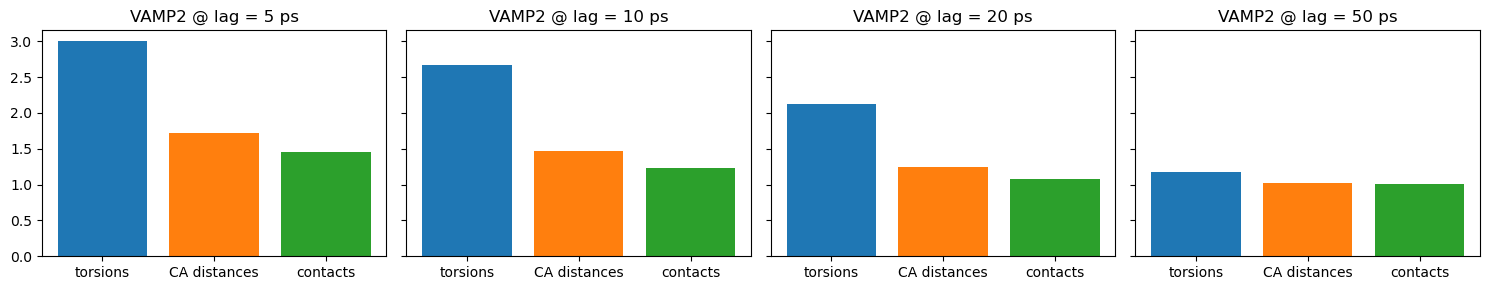

In [23]:
fig,axes = plt.subplots(1,4,figsize=(15,3),sharey=True)
plot_for_lag(axes[0],5)
plot_for_lag(axes[1],10)
plot_for_lag(axes[2],20)
plot_for_lag(axes[3],50)

From the PyEmma tutorial:

For the small lag time we see that there is a large gap between torsion angles on the one hand and CA distances and contacts on the other hand. For increasing lag times this gap vanishes, but also the overall score is decreasing (remember, however, models for different lag times are *not* directly comparable! - RAM). Because we have capped the maximum dimension or equivalently the score to contain only the three largest components of the underlying dynamical model, we can expect only a maximum score of three. As we increase the lag time, more of the fast kinetic processes have already decayed. So these are not contributing to the score anymore.

We have learned that backbone and sidechain torsions are better suited than the other features for modeling the kinetics, so we will continue with this feature.

### PCA 
We now perform a principal component analysis (PCA) with default parameters and visualize the marginal distributions of all PCs and the joint distributions of the first two PCs.

In [24]:
from sklearn.decomposition import PCA

For PCA, we can concatenate all the data from all the trajectories together into one big feature matrix.

In [25]:
dihsmatrix = np.vstack(dihslist_train+dihslist_test)

In [26]:
pca = PCA(n_components=2)
pca_concatenated = pca.fit_transform(dihsmatrix)

In [27]:
from helperfunctions import visFES2D

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(12,3))

pyemma.plots.plot_feature_histograms(
    pca_concatenated,
    ['PC {}'.format(i + 1) for i in range(2)],
    ax=axes[0])
pyemma.plots.plot_density(*pca_concatenated[:, :2].T, ax=axes[1], cbar=False)
#pyemma.plots.plot_free_energy(*pca_concatenated[:, :2].T, ax=axes[2], legacy=False)
contour = visFES2D(pca_concatenated,axes[2])
fig.colorbar(contour)
for ax in axes.flat[1:]:
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
fig.tight_layout()

We note it is possible to use our own function to visualize the free energy surface but two cautions: (1) this particular function is quite slow at the time of writing this and (2) it IS smoothed / fit with a Gaussian kernel density estimation, which I would recommend only using in conjunction with another non-smoothed visualization for safety's sake.

Text(0.5, 1.0, 'PC2')

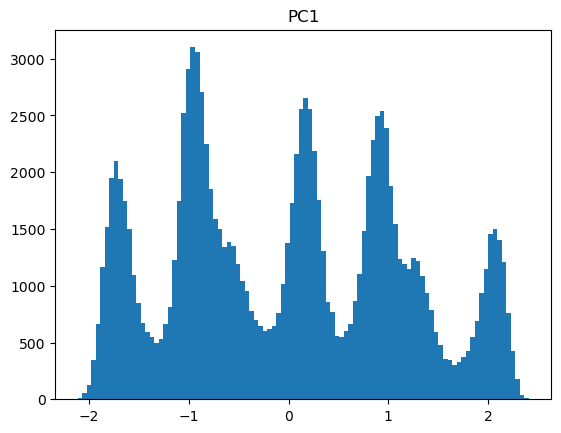

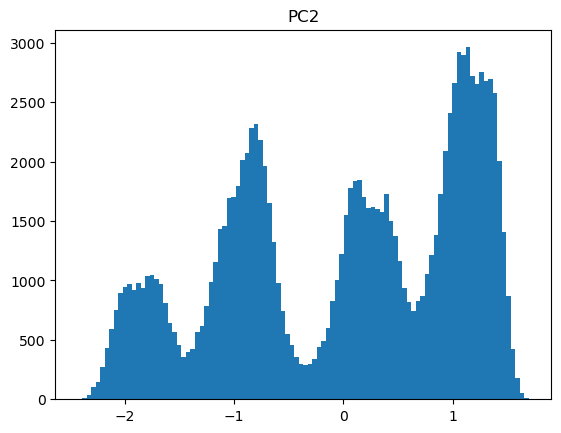

In [46]:

pc1 = pca_concatenated[:,0].reshape(-1)
pc2 = pca_concatenated[:,1].reshape(-1)
plt.figure()
plt.hist(pc1,bins=100)
plt.title('PC1')

plt.figure()
plt.hist(pc2,bins=100)
plt.title('PC2')

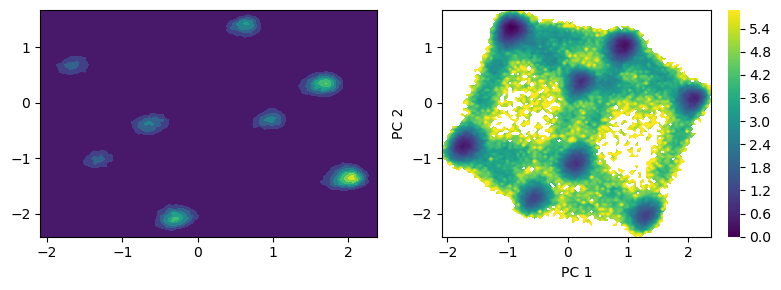

In [48]:
fig,axes = plt.subplots(1,2,figsize=(8,3))
deeptime.plots.plot_density(pc1,pc2, ax=axes[0])
energies = deeptime.util.energy2d(pc1,pc2)
deeptime.plots.plot_energy2d(energies,ax=axes[1])
for ax in axes.flat[1:]:
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
fig.tight_layout()

Compare the slight visualization differences between using PyEmma and using the equivalent deeptime functions to visualize these.

There's something funky going on with the `plot_density` function that I haven't found yet...it's reversing the order of the PCs, it looks like?

## TICA
Okay for this we're going to be using the `deeptime TICA` function: https://deeptime-ml.github.io/latest/notebooks/tica.html

We begin by following the PyEmma tutorial, which tells us:

> We have a look at some TICA projections estimated with the lag times given below and, for each lag time, we visualize the marginal distributions of all ICs and the joint distributions of the first two ICs. The actual dimension is determined by the default variance cutoff of 95%. This could be customized either by adjusting the var_cutoff or by requesting a certain number of dimensions with the dim keyword argument of tica().

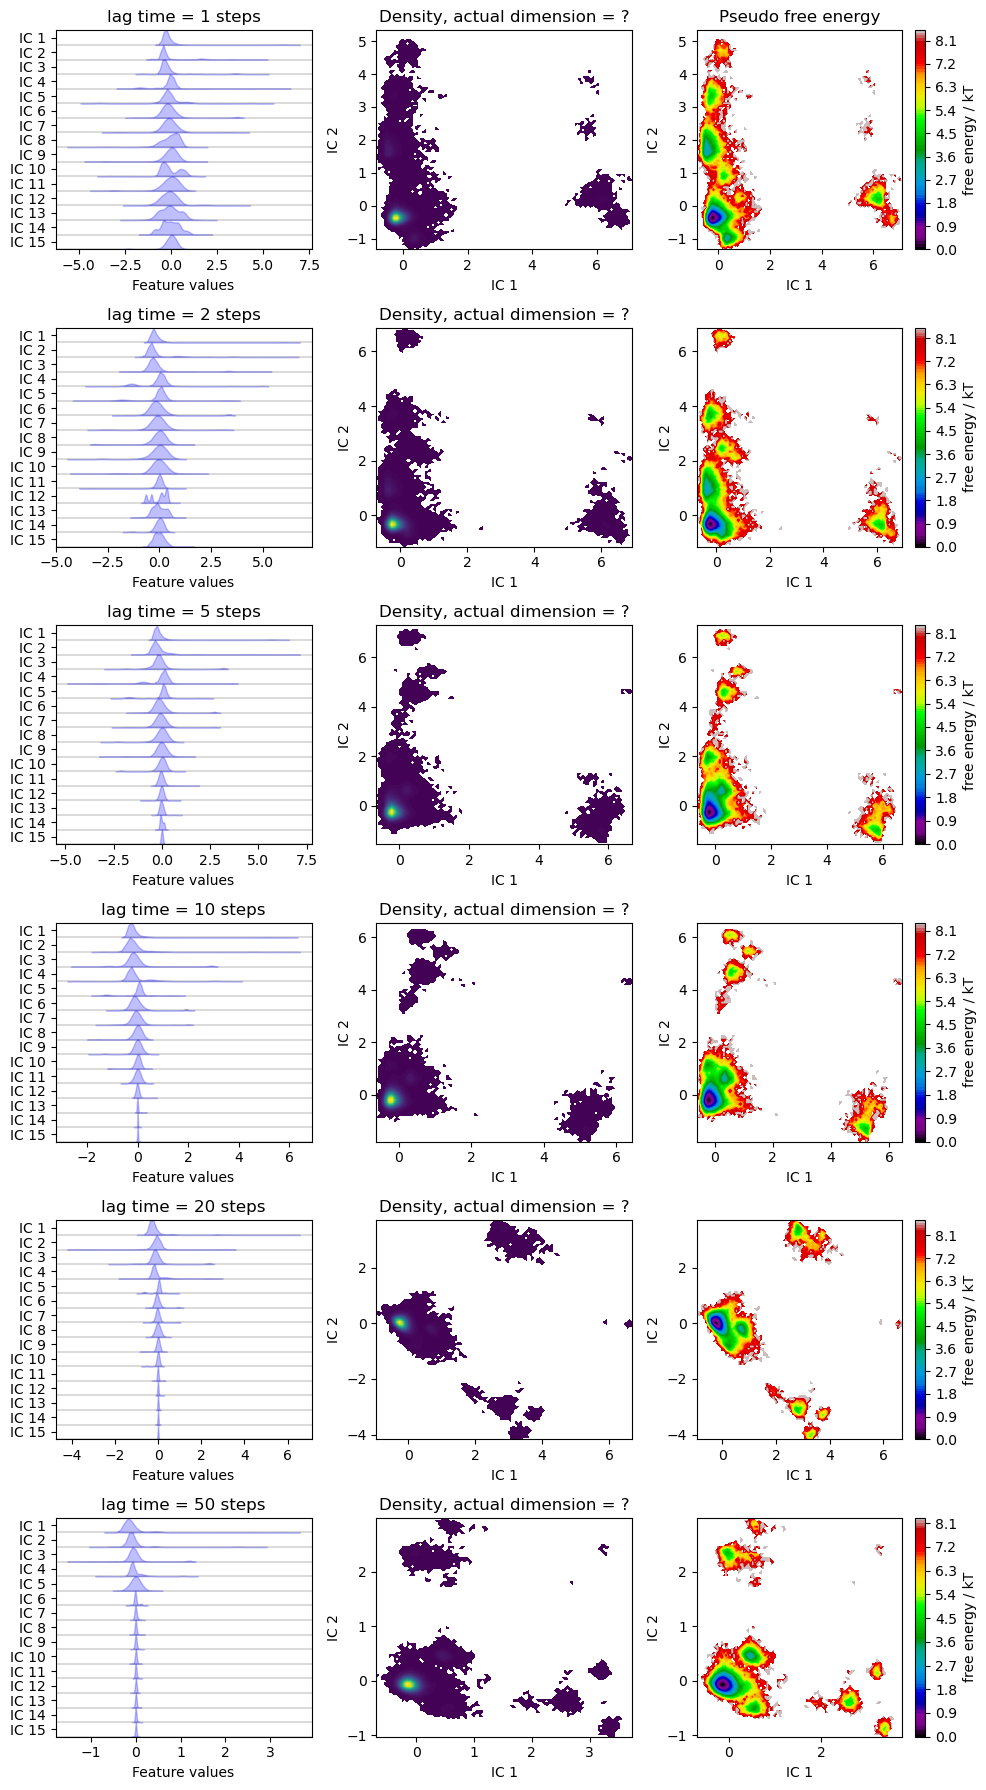

In [28]:
from deeptime.decomposition import TICA

lags = [1, 2, 5, 10, 20, 50]

fig, axes = plt.subplots(6, 3, figsize=(10, 18))
for i, lag in enumerate(lags):
    tica = TICA(lagtime=lag).fit(dihslist_train+dihslist_test).fetch_model()
    tica_concatenated = tica.transform(dihsmatrix)
    pyemma.plots.plot_feature_histograms(
        tica_concatenated[:,:15],
        ['IC {}'.format(i + 1) for i in range(15)],
        ax=axes[i, 0])
    axes[i, 0].set_title('lag time = {} steps'.format(lag))
    axes[i, 1].set_title(
        'Density, actual dimension = {}'.format('?'))
    pyemma.plots.plot_density(
        *tica_concatenated[:, :2].T, ax=axes[i, 1], cbar=False)
    pyemma.plots.plot_free_energy(
        *tica_concatenated[:, :2].T, ax=axes[i, 2], legacy=False)
for ax in axes[:, 1:].flat:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
axes[0, 2].set_title('Pseudo free energy')
fig.tight_layout()

The usage is very similar to the PyEmma usage, but deeptime's TICA doesn't automatically identify the top dimensions containing 95% of the kinetic variance, though we can clearly see that beyond the number of dimensions identified in the PyEmma tutorial (15, 13, 10, 8, 6, 4), everything is basically zeroed out.  From the PyEmma tutorial:
> Have you noticed that increasing the lag time 1. leads to a rotation of the projection and 2. reduces the number of TICs to explain 95% (default) of the kinetic variance?Note that, while we can get lower and lower dimensional subspaces with increased lag times, we also loose information from the faster processes. How to choose the optimal lag time for a TICA projection often is a hard problem and there are only heuristic approaches to it. For example, you can search for the amount of dimensions where the variance cutoff does not change anymore.

In [29]:
tica_concatenated.shape

(120024, 40)

(array([7.1430e+03, 9.8782e+04, 1.0437e+04, 1.4260e+03, 7.7000e+01,
        8.2000e+01, 9.9000e+01, 1.1470e+03, 4.5300e+02, 3.7800e+02]),
 array([-0.7098058 , -0.26332865,  0.18314851,  0.62962566,  1.07610282,
         1.52257997,  1.96905713,  2.41553428,  2.86201144,  3.3084886 ,
         3.75496575]),
 <BarContainer object of 10 artists>)

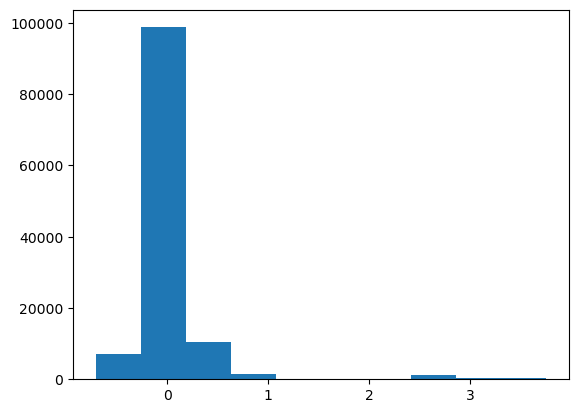

In [30]:
plt.hist(tica_concatenated[:,0])

In [31]:
np.std(tica_concatenated[:,7])

0.025725122924007325

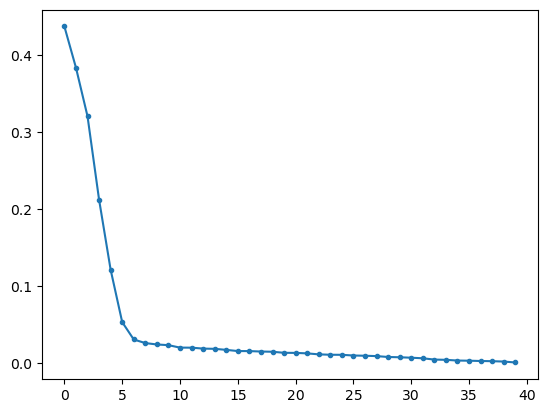

In [32]:
plt.plot(np.std(tica_concatenated,axis=0),'.-')

We can see that the variance drops and levels off after about 7 ICs in the case of the final lag time.

<BarContainer object of 40 artists>

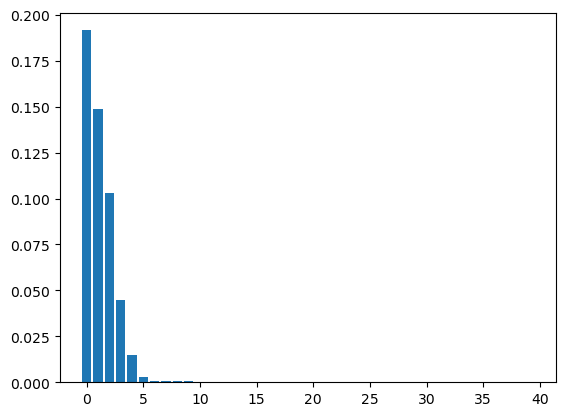

In [33]:
plt.bar(np.arange(len(tica.singular_values)),tica.singular_values**2)

Similarly, the eigenvalues (the square of the singular values) display a spectral gap somewhere between ~4-5 ICs.

We can get an automatic estimation by applying the L Method of Salvador and Chan, which basically fits two lines to the data and chooses the point to split where the two lines have the minimum combined root mean squared error (weighted for the size of the line.)  For this we will be using the in-house function `LMethodGapID` defined in `helperfunctions.py`

In [34]:
from helperfunctions import LMethodGapID

(5, array([-0.04574014,  0.19199983]), array([-3.01303223e-05,  9.33645231e-04]), 0.00343019209119743)


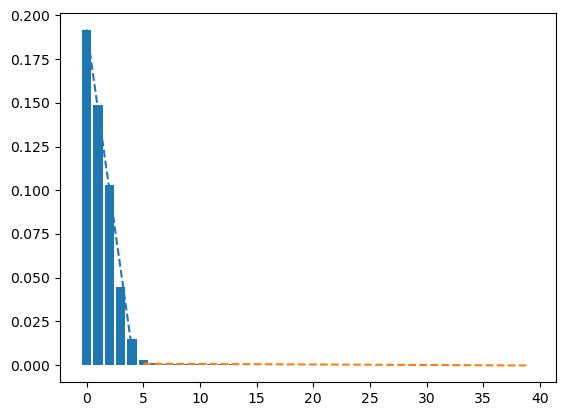

In [35]:
opt_split = LMethodGapID(tica.singular_values**2,plot=True)
print(opt_split)

For our update, we'd like to assess the number of dimensions to use but also we note from the deeptime documentation that *Koopman reweighting* is a "technique [that] becomes necessary as soon as the available data is not a single long trajectory which equilibrates and then is in an equilibrium state for the rest of the time but rather if many short and at least initially off-equilibrium trajectories are used." Which strictly speaking is our use case.  So we really should look into Koopman reweighting for TICA as well as identifying a spectral gap for our top features.

https://deeptime-ml.github.io/latest/notebooks/tica.html#Koopman-reweighting

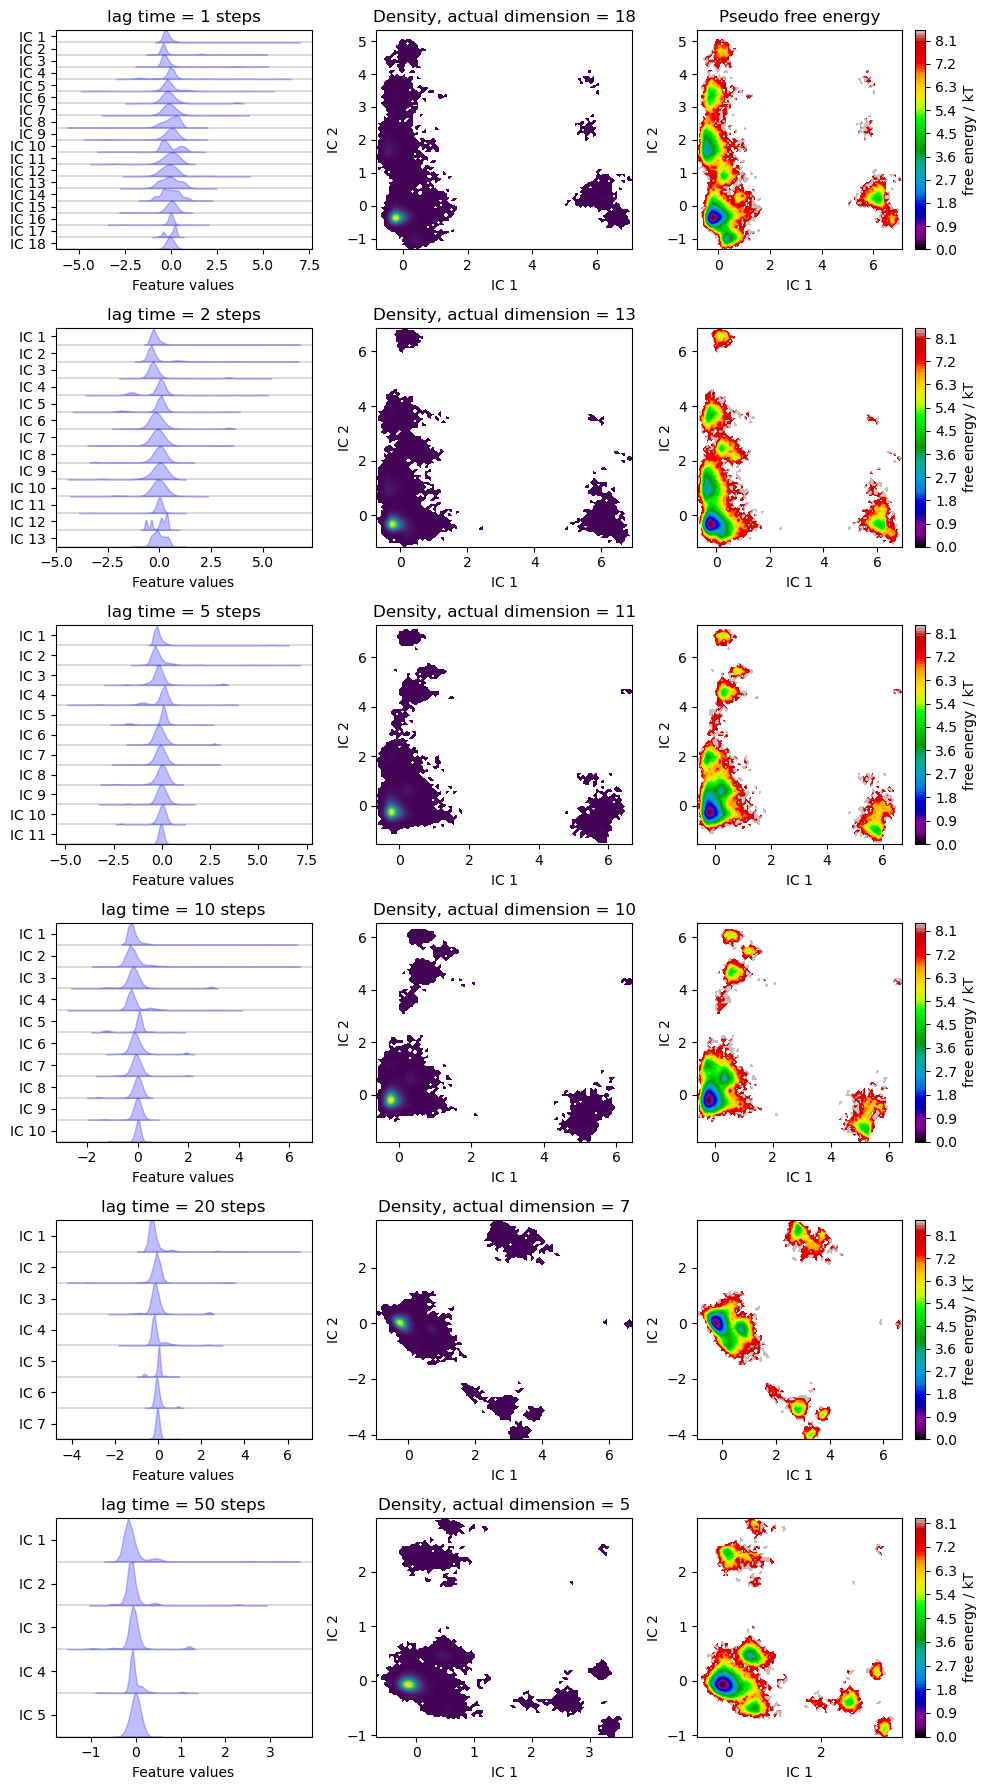

In [37]:
from deeptime.decomposition import TICA

lags = [1, 2, 5, 10, 20, 50]

fig, axes = plt.subplots(6, 3, figsize=(10, 18))
for i, lag in enumerate(lags):
    tica = TICA(lagtime=lag).fit(dihslist_train+dihslist_test).fetch_model()
    opt_split = LMethodGapID(tica.singular_values**2,plot=False)
    maxrank = opt_split[0]
    tica_concatenated = tica.transform(dihsmatrix)
    pyemma.plots.plot_feature_histograms(
        tica_concatenated[:,:maxrank],
        ['IC {}'.format(i + 1) for i in range(maxrank)],
        ax=axes[i, 0])
    axes[i, 0].set_title('lag time = {} steps'.format(lag))
    axes[i, 1].set_title(
        'Density, actual dimension = {}'.format(maxrank))
    pyemma.plots.plot_density(
        *tica_concatenated[:, :2].T, ax=axes[i, 1], cbar=False)
    pyemma.plots.plot_free_energy(
        *tica_concatenated[:, :2].T, ax=axes[i, 2], legacy=False)
for ax in axes[:, 1:].flat:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
axes[0, 2].set_title('Pseudo free energy')
fig.tight_layout()

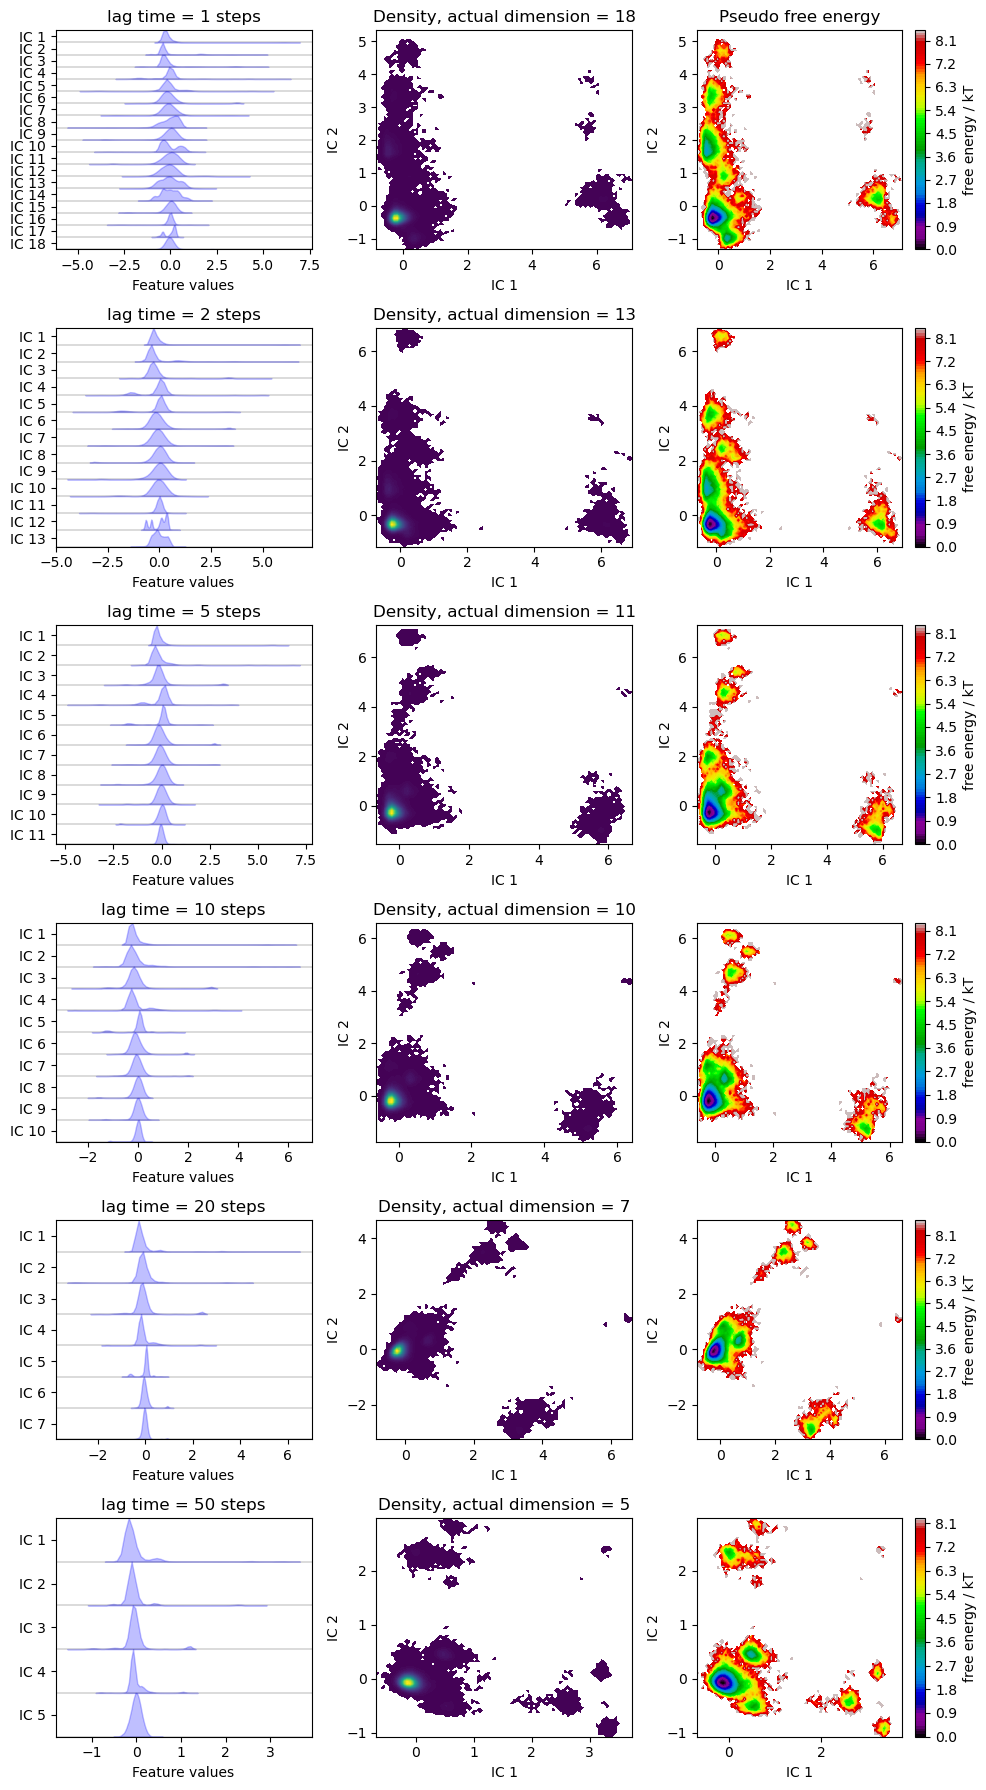

In [38]:
from deeptime.decomposition import TICA
from deeptime.covariance import KoopmanWeightingEstimator

lags = [1, 2, 5, 10, 20, 50]

fig, axes = plt.subplots(6, 3, figsize=(10, 18))
for i, lag in enumerate(lags):
    koopman_estimator = KoopmanWeightingEstimator(lagtime=lag)
    reweighting_model = koopman_estimator.fit(dihslist_train+dihslist_test).fetch_model()
    tica = TICA(lagtime=lag).fit(dihslist_train+dihslist_test,weights=reweighting_model).fetch_model()
    opt_split = LMethodGapID(tica.singular_values**2,plot=False)
    maxrank = opt_split[0]
    tica_concatenated = tica.transform(dihsmatrix)
    pyemma.plots.plot_feature_histograms(
        tica_concatenated[:,:maxrank],
        ['IC {}'.format(i + 1) for i in range(maxrank)],
        ax=axes[i, 0])
    axes[i, 0].set_title('lag time = {} steps'.format(lag))
    axes[i, 1].set_title(
        'Density, actual dimension = {}'.format(maxrank))
    pyemma.plots.plot_density(
        *tica_concatenated[:, :2].T, ax=axes[i, 1], cbar=False)
    pyemma.plots.plot_free_energy(
        *tica_concatenated[:, :2].T, ax=axes[i, 2], legacy=False)
for ax in axes[:, 1:].flat:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
axes[0, 2].set_title('Pseudo free energy')
fig.tight_layout()

In the end, we don't see a significant difference.